### データ読み込み

In [10]:
import numpy as np
csv_path = "mtfuji_data.csv" # ファイル名（パス）を指定する
np.set_printoptions(suppress=True) # 指数表示の禁止を設定する
fuji = np.loadtxt(csv_path, delimiter=",", skiprows=1)
print(fuji[:10])

[[   0.         35.134141  139.132082    0.          0.      ]
 [   1.         35.135826  139.129202    0.        322.      ]
 [   2.         35.13751   139.126322    0.        644.      ]
 [   3.         35.139194  139.123441    0.        966.      ]
 [   4.         35.140878  139.12056     0.       1288.      ]
 [   5.         35.142562  139.117679    0.       1611.      ]
 [   6.         35.144246  139.114799    6.62     1933.      ]
 [   7.         35.145929  139.111917    7.21     2255.      ]
 [   8.         35.147613  139.109036   12.2      2577.      ]
 [   9.         35.149297  139.106155   54.41     2899.      ]]


# 【問題1】データの可視化
Matplotlibを使い標高データを可視化してください。横軸に「その地点の番号」、縦軸に「標高」を設定すれば、富士山の断面図が描けます。


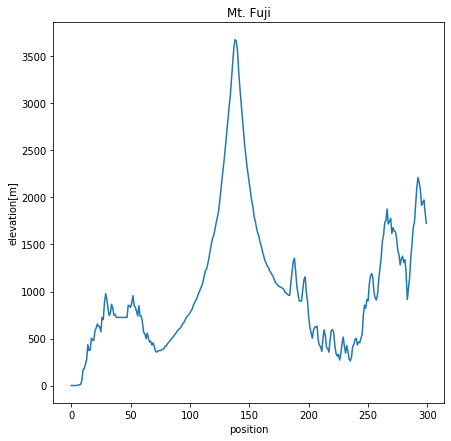

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(7, 7))

plt.title("Mt. Fuji")
plt.xlabel("position")
plt.ylabel("elevation[m]")

plt.plot(fuji[:,0], fuji[:,3])
plt.show()

In [190]:
# 関数化
def plt_data(arr_x, arr_y, position="step"):
    fig = plt.figure(figsize=(7, 7))
    plt.title("Mt. Fuji")
    plt.xlabel("position")
    plt.ylabel("elevation[m]")
    plt.plot(fuji[:,0], fuji[:,3])
    plt.plot(arr_x,arr_y, marker ='o', label=position)
    plt.legend(bbox_to_anchor=(1,1))
    
    return plt.show()

# 【問題2】ある地点の勾配を計算する関数を作成
「二次元配列と勾配問題」では各地点での勾配を最初に求めました。しかし、暗闇の富士山を想像すると、知ることができるのは今いる地点の勾配だけです。


「今いる地点の番号」と「今いる隣の地点の番号（今いる地点の番号-1）」の関係による勾配を求める関数を作成してください。


勾配は以下の式で求まりましたが、このデータでは「標高」がy、「その地点の番号」がxに相当します。

In [4]:
# 勾配を計算する関数
def compute_gradient_Fuji(position):
    if position == 0 and (fuji[position][3] - fuji[position+1][3]) >= 0: # 位置がゼロ、かつ隣との高さの差がゼロ以下の場合(1の方が高いなど)
        return 0 # 勾配をゼロで返す　→　どこにも移動して欲しくないので。
    elif position == (len(fuji[:,0])-1) and (fuji[position][3] - fuji[position-1][3]) <= 0: # 逆に299、かつ298の方が高い時
        return 0 # 勾配ゼロ
    else:　# それ以外は公式に従う
        dx = fuji[position][0] - fuji[position-1][0]
        dy = fuji[position][3] - fuji[position-1][3]
        gradident = dy / dx
        return gradident # 出力の勾配


print(compute_gradient_Fuji(1))

0.0


# 【問題3】移動先の地点を計算する関数を作成
今いる地点の勾配の情報を元に、次に移動先の地点を計算する関数を作成してください。


数式で表すと 「移動先の地点 = 今いる地点 - $\alpha$ ×今いる地点の勾配」 となります。


「今いる地点の勾配」は問題2で作成した関数の返り値を使用してください。$\alpha$ は0より大きい任意の値をとるハイパーパラメータです。機械学習の分野では学習率という名前で呼ばれます。この値によって下り方が変わります。ここでは例えば0.2に設定してください。


《実装上の注意》


上記式を計算すると移動先の地点には浮動小数点数が現れますが、今回勾配の情報を得るためには地点は整数で表す必要があります。そのため、四捨五入による変換を行ってください。また、取り得ない値となった場合の処理が必要です。例えば移動先の地点が負になると、そのようなデータが存在しないため、次に勾配が得られなくなります。


《ハイパーパラメータとは》


機械学習手法において、その手法自身では最適化が行えない値のことです。値によって手法の挙動は変化し、学習がうまくいくかどうかに影響を与えるため、設定は慎重に行う必要があります。最も単純には人間が考えて設定することになりますが、ハイパーパラメータを機械的に決めるための手法も存在します。

In [58]:
from decimal import Decimal, ROUND_HALF_UP

# 移動先を出力する関数
def next_step(position, alpha=0.2): # アルファはハイパーパラメータ、変数で変更できるようにする
    grad = compute_gradient_Fuji(position) # 勾配関数から勾配を出す
    x = position - (alpha * grad) # 次の地点を計算
    x = Decimal(x).quantize(Decimal('0'), ROUND_HALF_UP) # 四捨五入
    
    # リスト内の数値だったらそのまま出力し、オーバーしてたらminとmaxを出す
    if len(fuji[:,0]) > x >= 0:
        return int(x)
    elif x < 0:
        return 0
    elif x > len(fuji[:,0])-1:
        return len(fuji[:,0])-1

print(next_step(136))

102


# 【問題4】山を下る関数を作成
山を下る関数を作成してください。最初の地点を受け取り、問題3の関数によって地点を更新していきます。移動毎の地点はリストなどに記録して、これを関数の返り値としてください。


最初の「今いる地点」は富士山の頂上付近、136番の地点（標高3434.59[m]）とします。ここから山を下っていきましょう。


《実装上の注意》


問題3で四捨五入を行っているため、移動先の地点が今いる地点と同じ場合になることがあります。移動量が減ってきたということなので、その時点で山を下りきったと判断してください。実際の勾配降下法ではこのようなことは起きません。

In [187]:
# forで回すver

#山を降る関数
def roll_over(position): 
    lst = [position] # 移動履歴を格納するリスト、初期値をセット
    x = next_step(position) # 一歩目を出力
    
    for _ in range(fuji.shape[0]-1): # リストの列数分for回す
        if x == lst[-1]: # 最初に終了条件を設定、リストの最後の値と移動先が同じだった場合終了する
            break
        lst.append(x) # 同じじゃない場合はリストに格納
        x = next_step(x) # さらに次の移動先を計算
    
    return lst # forが最後まで回る、もしくはifブロックを通過してbreakするとリストを出力する

x_list =  roll_over(136)
print(x_list)
print(len(x_list))

[136, 102, 98, 95, 93, 89, 85, 82, 79, 73, 70, 78, 77, 75]
14


In [185]:
# 再帰関数ver

def gradient_decending(position,alpha=0.2, lst=[]):
    if len(lst) == 0: # リストのサイズが0だったら初期値を代入
        lst.append(position)
    
    x = next_step(position, alpha) # 次の移動先を計算
    
    # 現在地と移動先が同じだった場合
    if position == x:
        out = lst  # 出力用リストに代入
        lst = [] # リストを初期化
        return out

    lst.append(x) # xをリストに代入
    return gradient_decending(x, alpha, lst) # xとリストを再帰して次の移動先を探しにいく

tmp = [136,145,102,166]

for i in tmp:
    lst = []
    try:
        alpha = 0.2
        print(gradient_decending(i,alpha, lst))

    except RecursionError as e:
        print("再帰上限を超えました。 :  初期値[{}]".format(i))
        print("２連続で同じ数字になりません。αを調整してください。")
        print(type(e))
        print(e)



[136, 102, 98, 95, 93, 89, 85, 82, 79, 73, 70, 78, 77, 75]
再帰上限を超えました。 :  初期値[145]
２連続で同じ数字になりません。αを調整してください。
<class 'RecursionError'>
maximum recursion depth exceeded in comparison
[102, 98, 95, 93, 89, 85, 82, 79, 73, 70, 78, 77, 75]
再帰上限を超えました。 :  初期値[166]
２連続で同じ数字になりません。αを調整してください。
<class 'RecursionError'>
maximum recursion depth exceeded in comparison


### 再帰関数について

問題文を読んだときに、再帰処理のが向いているのでは？と思い再帰関数を作ってみたが、１０００回内では終わらないパターンが頻発した。
今回のように終了条件が一意の場合、どちらかといえばちゃんと終わるパターンの方が少ない気もするので、whileや再帰は向いていないのかもしれない。
forで一定回数回して、明らかにリストが長い場合などにαを変更してみる、といった対応が良いか？

もしくは、再帰上限を超えた場合はαを半分にして、もう一度再帰するような形の物が良いか？

In [188]:
# というわけで再帰の再帰やってみたver
tmp = [136,145,0,166,296]

for i in tmp:
    lst = []
    try:
        alpha = 0.2
        print(gradient_decending(i,alpha, lst))

    except RecursionError as e:
        print(type(e))
        print(e)
        print("再帰上限を超えました。 : 　初期値[{}]".format(i))
        print("２連続で同じ数字になりません。alphaを半分にして再帰します。")

        
        try:
            lst = []
            alpha = alpha / 2
            print("再再帰した結果 : {}".format(gradient_decending(i, alpha, lst)))
            
        except RecursionError as e:
            print("再帰上限を超えました。 : 　初期値[{}]".format(i))
            print("alpha半分でもうまく回らない。要確認。")


[136, 102, 98, 95, 93, 89, 85, 82, 79, 73, 70, 78, 77, 75]
<class 'RecursionError'>
maximum recursion depth exceeded in comparison
再帰上限を超えました。 : 　初期値[145]
２連続で同じ数字になりません。alphaを半分にして再帰します。
再再帰した結果 : [145, 160, 164, 167, 171, 175, 176]
[0]
<class 'RecursionError'>
maximum recursion depth exceeded in comparison
再帰上限を超えました。 : 　初期値[166]
２連続で同じ数字になりません。alphaを半分にして再帰します。
再再帰した結果 : [166, 167, 171, 175, 176]
<class 'RecursionError'>
maximum recursion depth exceeded in comparison
再帰上限を超えました。 : 　初期値[296]
２連続で同じ数字になりません。alphaを半分にして再帰します。
再再帰した結果 : [296, 293, 298, 299]


<br>

ひとまずα=0.1なら0.2よりもエラーは出ないが、逆にほとんど山降ってない。
次のセルは地点166からα=0.1で降った場合。

<br>



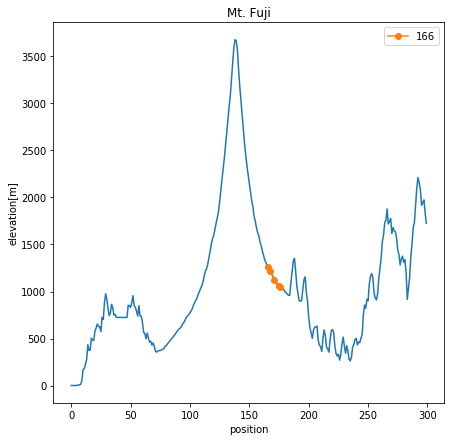

In [193]:
x_list = gradient_decending(166, 0.1, lst=[])
y_list = [fuji[x][3] for x in x_list]
#print(y_list)

plt_data(x_list, y_list,166)

<br>
せめて184くらいまでは行って欲しかったので、数値を色々試していたらα=0.12くらいが良さげだったので無理やり指定。


In [139]:
tmp = [136,142,0,166,235]

for i in tmp:
    lst = []
    try:
        alpha = 0.2
        print(gradient_decending(i,alpha, lst))

    except RecursionError as e:
        print(type(e))
        print(e)
        print("再帰上限を超えました。 : 　初期値[{}]".format(i))
        print("２連続で同じ数字になりません。alphaを0.12にして再帰します。")

        try:
            lst = []
            alpha = 0.12
            print(gradient_decending(i, alpha, lst))
            
        except RecursionError as e:
            print("再帰上限を超えました。 : 　初期値[{}]".format(i))
            print("alpha=0.12でもうまく回らない。要確認。")

[136, 102, 98, 95, 93, 89, 85, 82, 79, 73, 70, 78, 77, 75]
<class 'RecursionError'>
maximum recursion depth exceeded in comparison
再帰上限を超えました。 : 　初期値[142]
２連続で同じ数字になりません。alphaを0.12にして再帰します。
[142, 163, 169, 171, 175, 177, 178, 179, 180, 183, 184]
[0]
<class 'RecursionError'>
maximum recursion depth exceeded in comparison
再帰上限を超えました。 : 　初期値[166]
２連続で同じ数字になりません。alphaを0.12にして再帰します。
[166, 168, 171, 175, 177, 178, 179, 180, 183, 184]
<class 'RecursionError'>
maximum recursion depth exceeded in comparison
再帰上限を超えました。 : 　初期値[235]
２連続で同じ数字になりません。alphaを0.12にして再帰します。
再帰上限を超えました。 : 　初期値[235]
alpha=0.12でもうまく回らない。要確認。


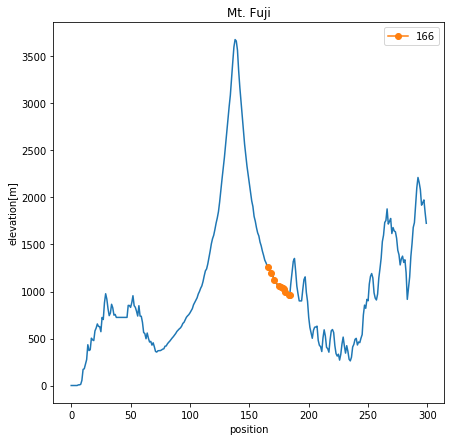

In [194]:
# 166からα=0.12で降る
x_list = gradient_decending(166, 0.12, lst=[])
y_list = [fuji[x][3] for x in x_list]
#print(y_list)

plt_data(x_list, y_list,166)

166のときに184までは行ってくれたが、これでもまだ場所によってエラー出ている。

こうなるとαを0.01ずつ調整していく作業になると思うので、ひとまず今回はforでやった方が早いと判断しここで終了する。

ただ、膨大なデータを扱う場合はforも難しくなると思うので、再帰してα調整の形になると思われる。

### 最後に念のため時間計測

In [151]:
%%timeit

roll_over(136)

69.2 µs ± 1.01 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [150]:
%%timeit

gradient_decending(136, 0.1, lst=[])

90.7 µs ± 1.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


forの方が早い、、、
データが増えたら違うかも？

# 【問題5】下山過程の可視化
問題4における下山過程をMatplotlibを使いグラフで可視化してください。


《可視化例》


・断面図の中に移動した地点を点で表示する


・繰り返し毎の標高や勾配を折れ線グラフにする

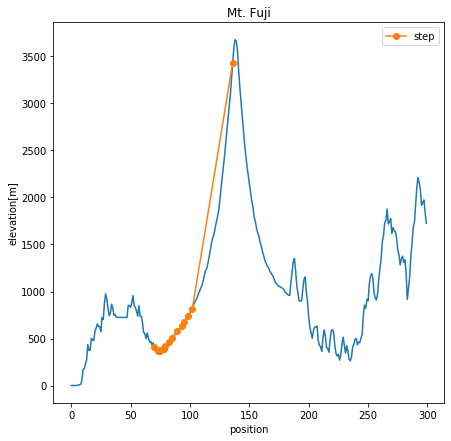

In [195]:
%matplotlib inline

x_list = roll_over(136)
y_list = [fuji[x][3] for x in x_list]
#print(y_list)

plt_data(x_list, y_list,"step")

# 【問題6】初期値の変更
問題4では最初の「今いる地点」を136としましたが、これを他の全ての点で計算してください。そして、いくつかの初期値に対してどのような下山過程となるか、問題5のように可視化してください。機械学習においては 初期値 をどう設定するかが結果に影響を与えることが確認できます。


《初期値とは》


今回の例での最初の地点のような値を初期値と呼びます。これを変更すると結果が変化します。例えば136と142では富士山の異なるの斜面を下ることになります。



In [173]:
all_point = fuji[:,0] # FUJIの0列目を全て取得

all_point_dict = {} # 格納辞書を宣言

for i in all_point:
    tmp = roll_over(int(i)) # intで指定しないとうまく行かない、スライシングするのにfloat型は使えない。
    all_point_dict[int(i)] = tmp # 辞書のキーはどっちでもいいけどなんとなくint

print(all_point_dict)
    

{0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6, 5], 7: [7], 8: [8, 7], 9: [9, 1], 10: [10, 0], 11: [11, 10, 0], 12: [12, 2], 13: [13, 4], 14: [14, 0], 15: [15, 27, 31, 51, 41], 16: [16, 14, 0], 17: [17, 0], 18: [18, 22, 13, 4], 19: [19, 21, 15, 27, 31, 51, 41], 20: [20, 0], 21: [21, 15, 27, 31, 51, 41], 22: [22, 13, 4], 23: [23, 28, 0], 24: [24], 25: [25, 36, 52, 37, 35, 43], 26: [26, 0], 27: [27, 31, 51, 41], 28: [28, 0], 29: [29, 10, 0], 30: [30, 41], 31: [31, 51, 41], 32: [32, 47], 33: [33, 27, 31, 51, 41], 34: [34, 15, 27, 31, 51, 41], 35: [35, 43], 36: [36, 52, 37, 35, 43], 37: [37, 35, 43], 38: [38, 44], 39: [39], 40: [40], 41: [41], 42: [42], 43: [43], 44: [44], 45: [45], 46: [46], 47: [47], 48: [48, 22, 13, 4], 49: [49], 50: [50, 54, 58, 80], 51: [51, 41], 52: [52, 37, 35, 43], 53: [53, 74], 54: [54, 58, 80], 55: [55, 63, 74], 56: [56, 66, 74], 57: [57, 35, 43], 58: [58, 80], 59: [59], 60: [60, 73, 70, 78, 77, 75], 61: [61, 83, 80], 62: [62, 64, 52, 37, 35, 43], 63: [63

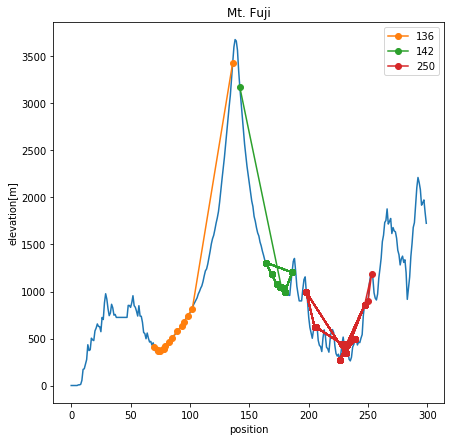

In [202]:
# いくつかの地点からの移動をプロット

x_list = all_point_dict[136]
y_list = [fuji[x][3] for x in x_list]
#print(y_list)

x_list_2 = all_point_dict[142]
y_list_2 = [fuji[x][3] for x in x_list_2]

x_list_3 = all_point_dict[250]
y_list_3 = [fuji[x][3] for x in x_list_3]


fig = plt.figure(figsize=(7, 7))
plt.title("Mt. Fuji")
plt.xlabel("position")
plt.ylabel("elevation[m]")
plt.plot(fuji[:,0], fuji[:,3])
plt.plot(x_list,y_list, marker ='o', label="136")
plt.plot(x_list_2, y_list_2, marker = 'o', label = "142")
plt.plot(x_list_3, y_list_3, marker = 'o', label = "250")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()